In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [5]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]

In [7]:
# distance matrix

In [8]:
## correlation matrix
from scipy.spatial.distance import pdist, squareform

In [9]:
# get JSD
fdata=data_all.copy()
kld = squareform(pdist(fdata, metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata.index.get_level_values('age').to_numpy()

In [10]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

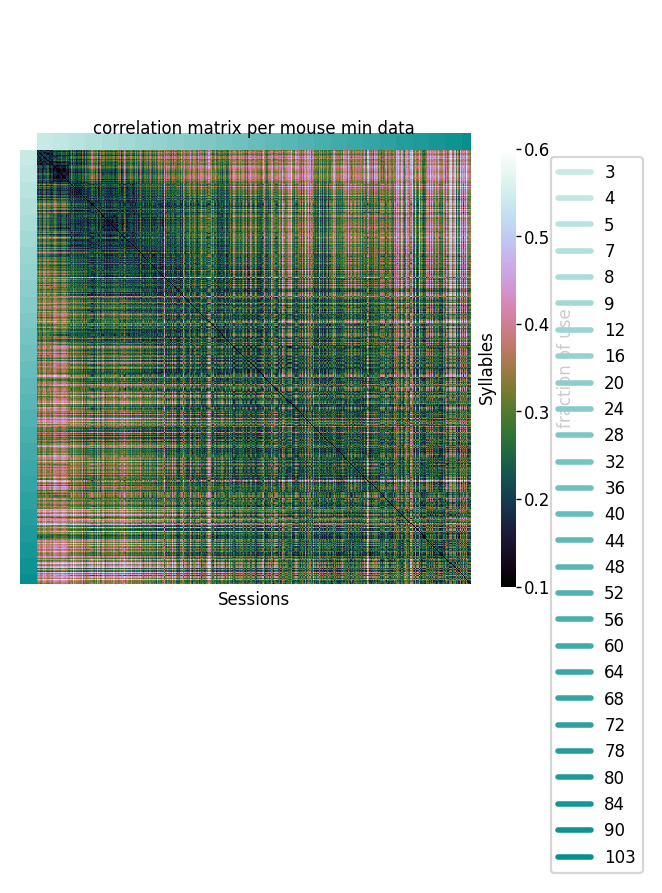

In [11]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    #metric='cosine',
    rasterized=True,
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('correlation matrix per mouse min data')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [12]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ 'male_distance.pdf')

In [13]:
##for pcs

In [26]:
data=data_all.copy()
ages2 = data.index.get_level_values('age')
mice = data.index.get_level_values('uuid')

In [27]:
pcs = PCA(n_components=2).fit_transform(data)
pc_df = pd.DataFrame(pcs)
pc_df.columns = pc_df.columns.astype(str)
pc_df['age'] = ages2
pc_df['mice'] = mice

In [28]:
from sklearn.metrics import pairwise_distances
#pc_tmp = pc_df[['0','1','2','3','4','5','6','7','8','9','10','11']].to_numpy()
pc_tmp = pc_df[['0','1']].to_numpy()
utemp = pairwise_distances(pc_tmp)
kld = squareform(pdist(pc_tmp, metric='jensenshannon'))
ctemp = pairwise_distances(pc_tmp, metric = 'cosine')

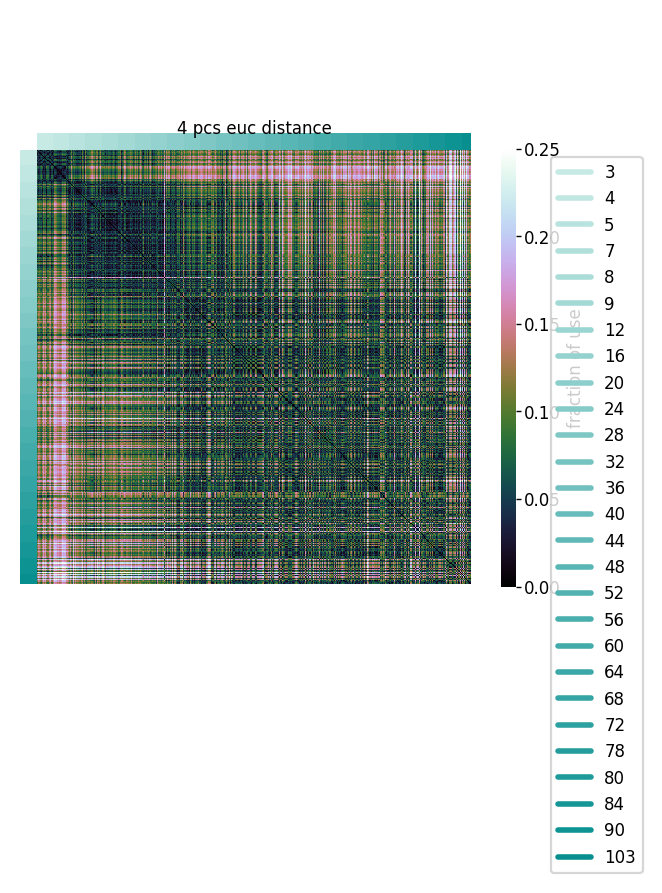

In [31]:
cg=sns.clustermap(
    data=utemp,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    rasterized=True,
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0,
    vmax=0.25)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_title('4 pcs euc distance')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [30]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ 'male_distance_2pcs.pdf')

In [19]:
npc = 12
pca = PCA(n_components=npc)
#pcsn = pca.fit_transform(np.log(data + 1e-6))
pcsn = pca.fit_transform(data)
ages = data.index.get_level_values('age')
pcn_df = pd.DataFrame(pcsn)
pcn_df['age'] = ages

In [20]:
# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)

[0.39896105 0.60612841 0.68103102 0.72385056 0.76446384 0.79951842
 0.82905572 0.85210731 0.86989661 0.8853911  0.89794536 0.90982735]
